# OpenAI Responses API: Complete Tutorial

## Overview

The OpenAI Responses API is a superset of Chat Completions, meaning everything you can do with Chat Completions can be done with the Responses API, plus additional features. This unified interface simplifies building AI applications with built-in tools, conversation management, and enhanced capabilities.

### Key Features
- **Simplified Interface**: Single API for complex interactions
- **Built-in Tools**: Web search, file search, computer use
- **Stateful Conversations**: Automatic conversation management
- **Structured Outputs**: Type-safe responses with Pydantic
- **Enhanced Function Calling**: Custom tool integration

## Setup

In [ ]:
# Uncomment to install required packages
# !pip install openai python-dotenv

In [36]:
import os
from openai import OpenAI
from dotenv import load_dotenv
import json
from IPython.display import Markdown, display

# Load environment variables
load_dotenv()

# Initialize client
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

## 1. Basic Text Generation

In [5]:
# Simple text generation
response = client.responses.create(
    model="gpt-4o",
    input="Write a haiku about artificial intelligence."
)

display(Markdown(response.output_text))

Machine minds awake,  
Patterns dance in circuits bright—  
Whispers of the code.

### Instructions vs Input

In [35]:
# Using instructions for system-level guidance
response = client.responses.create(
    model="gpt-4o",
    instructions="You are a helpful coding assistant. Always provide working code examples.",
    input="How do I read a CSV file in Python?"
)

print(response.output_text)

To read a CSV file in Python, you can use several methods. Here are two common ways using built-in and external libraries:

### Method 1: Using the `csv` module

```python
import csv

# Specify the path to your CSV file
csv_file_path = 'your_file.csv'

# Open the file and read its contents
with open(csv_file_path, mode='r', newline='') as file:
    csv_reader = csv.reader(file)
    
    # Iterate over each row in the CSV
    for row in csv_reader:
        print(row)
```

### Method 2: Using `pandas`

```python
import pandas as pd

# Specify the path to your CSV file
csv_file_path = 'your_file.csv'

# Read the CSV file using pandas
df = pd.read_csv(csv_file_path)

# Display the contents of the DataFrame
print(df)
```

### Key Differences:
- The `csv` module is part of Python's standard library and provides simple handling for CSV file reading.
- `pandas` is an external library that provides more powerful data manipulation capabilities. If you need to perform more complex operations on y

## 2. Conversation State Management

### Manual State Management

In [7]:
# Build conversation manually
conversation = [
    {"role": "user", "content": "What's the capital of France?"},
    {"role": "assistant", "content": "The capital of France is Paris."},
    {"role": "user", "content": "What's the population?"}
]

response = client.responses.create(
    model="gpt-4o-mini",
    input=conversation
)

display(Markdown(response.output_text))

As of my last update, the population of Paris is approximately 2.1 million people within the city limits. However, the larger metropolitan area has a population of around 11 million. For the most current figures, it's always a good idea to check official statistics.

### Automatic State Management

In [9]:
# Let OpenAI handle conversation state
response1 = client.responses.create(
    model="gpt-4o-mini",
    input="Tell me about Python programming in 20 words."
)

# Continue conversation using previous response ID
response2 = client.responses.create(
    model="gpt-4o-mini",
    previous_response_id=response1.id,
    input="What are its main advantages in 20 words?"
)

print("First response:")
display(Markdown(response1.output_text))
print("\nSecond response:")
display(Markdown(response2.output_text))

First response:


Python is a versatile, high-level programming language known for its readability, simplicity, and extensive libraries for various applications.


Second response:


Python offers simplicity, readability, extensive libraries, community support, cross-platform compatibility, rapid development, strong integration capabilities, and versatility for multiple domains.

## 3. Function Calling

Simple demo of OpenAI function calling - AI decides when to call your custom functions.

**How it works:**
1. Define a Python function  
2. Describe it to OpenAI with a tool schema  
3. AI automatically calls it when needed  
4. You execute the function and see the result

In [10]:
import requests

def get_weather(city):
    """Get weather using a simple API"""
    try:
        # Simple weather API that returns JSON
        url = f"https://wttr.in/{city}?format=j1"
        data = requests.get(url, timeout=5).json()
        temp = data["current_condition"][0]["temp_C"]
        desc = data["current_condition"][0]["weatherDesc"][0]["value"]
        return f"🌤️ {city}: {temp}°C, {desc}"
    except:
        return f"🌤️ {city}: 22°C, Sunny (demo data)"

# Define the tool for OpenAI
tools = [{
    "type": "function",
    "name": "get_weather",
    "description": "Get weather for a city",
    "parameters": {
        "type": "object",
        "properties": {"city": {"type": "string"}},
        "required": ["city"]
    }
}]

# Call OpenAI with the tool
response = client.responses.create(
    model="gpt-4o-mini",
    input="What's the weather in Tokyo?",
    tools=tools
)

# Execute any function calls
for output in response.output:
    if hasattr(output, 'type') and output.type == 'function_call':
        print(f"🤖 AI called: {output.name}({output.arguments})")
        
        # Execute the function
        import json
        args = json.loads(output.arguments)
        result = get_weather(**args)
        
        print(f"📊 Result: {result}")
        print("✅ Function calling works!")
        break

🤖 AI called: get_weather({"city":"Tokyo"})
📊 Result: 🌤️ Tokyo: 31°C, Partly cloudy
✅ Function calling works!


## 4. Structured Outputs

In [ ]:
from pydantic import BaseModel
from typing import List

# Define response structure
class EventDetails(BaseModel):
    name: str
    date: str
    participants: List[str]
    location: str

# Get the schema and add required additionalProperties field
schema = EventDetails.model_json_schema()
schema["additionalProperties"] = False

# Generate structured output
response = client.responses.create(
    model="gpt-4o",
    input="Alice and Bob are meeting for a coding workshop at the library on Friday.",
    # Define the output text format
    text={
        "format": {
            "type": "json_schema",
            "name": "event_extraction",
            "schema": schema,
            "strict": True
        }
    }
)

# Parse structured response
event_data = json.loads(response.output_text)
print(json.dumps(event_data, indent=2))

{
  "name": "Coding Workshop",
  "date": "Friday",
  "participants": [
    "Alice",
    "Bob"
  ],
  "location": "Library"
}


## 5. Built-in Tools

### Web Search

In [12]:
# Use web search tool
response = client.responses.create(
    model="gpt-4o",
    input="What are the latest developments in AI in 2025? give me top 5 sources only",
    tools=[{"type": "web_search_preview"}]
)

display(Markdown(response.output_text))

# Access citations
for output in response.output:
    if hasattr(output, 'content'):
        for content in output.content:
            if hasattr(content, 'annotations'):
                for annotation in content.annotations:
                    if annotation.type == 'url_citation':
                        print(f"Source: {annotation.title}")
                        print(f"URL: {annotation.url}")

As of August 2, 2025, the field of artificial intelligence (AI) has seen several significant developments:

1. **U.S. SEC Establishes AI Task Force**: The U.S. Securities and Exchange Commission (SEC) announced the formation of a new AI task force to enhance innovation and efficiency within its operations. Valerie Szczepanik has been appointed as the SEC's first Chief AI Officer to lead this initiative. ([reuters.com](https://www.reuters.com/technology/us-securities-regulator-announces-ai-task-force-2025-08-01/?utm_source=openai))

2. **China Proposes Global AI Cooperation Organization**: China has proposed creating an international organization to promote global cooperation on AI, aiming to provide an alternative to U.S.-led initiatives and foster inclusive development of the technology. Premier Li Qiang announced this at the World Artificial Intelligence Conference in Shanghai. ([reuters.com](https://www.reuters.com/world/china/china-proposes-new-global-ai-cooperation-organisation-2025-07-26/?utm_source=openai))

3. **Meta Launches 'Superintelligence' Lab**: Meta has established a new division, Meta Superintelligence Labs, to centralize and accelerate its AI efforts. Alexandr Wang, former CEO of Scale AI, has been appointed as Chief AI Officer to lead this initiative, focusing on advancements in artificial general intelligence (AGI). ([reuters.com](https://www.reuters.com/business/meta-deepens-ai-push-with-superintelligence-lab-source-says-2025-06-30/?utm_source=openai))

4. **Google Introduces 'AI Mode' in Search**: Google unveiled a new "AI Mode" in its search engine, allowing users to interact conversationally to receive expert-level answers. This feature integrates Google's Gemini 2.5 model and includes capabilities like automated ticket purchases and live video search functions. ([apnews.com](https://apnews.com/article/5b0cdc59870508dab856227185cb8e23?utm_source=openai))

5. **Advancements in AI Agents**: AI agents are evolving from simple co-pilots to sophisticated autonomous systems, referred to as "agentic AI." These agents can analyze data, understand context, and make independent decisions to achieve user-defined goals, transforming industries such as healthcare, finance, law, and retail. ([ft.com](https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f?utm_source=openai))

These developments highlight the rapid progress and diverse applications of AI across various sectors.


## Recent AI Developments in 2025:
- [US securities regulator announces AI task force](https://www.reuters.com/technology/us-securities-regulator-announces-ai-task-force-2025-08-01/?utm_source=openai)
- [China proposes new global AI cooperation organisation](https://www.reuters.com/world/china/china-proposes-new-global-ai-cooperation-organisation-2025-07-26/?utm_source=openai)
- [Meta deepens AI push with 'Superintelligence' lab, source says](https://www.reuters.com/business/meta-deepens-ai-push-with-superintelligence-lab-source-says-2025-06-30/?utm_source=openai) 

Source: US securities regulator announces AI task force
URL: https://www.reuters.com/technology/us-securities-regulator-announces-ai-task-force-2025-08-01/?utm_source=openai
Source: China proposes new global AI cooperation organisation
URL: https://www.reuters.com/world/china/china-proposes-new-global-ai-cooperation-organisation-2025-07-26/?utm_source=openai
Source: Meta deepens AI push with 'Superintelligence' lab, source says
URL: https://www.reuters.com/business/meta-deepens-ai-push-with-superintelligence-lab-source-says-2025-06-30/?utm_source=openai
Source: Google's unleashes 'AI Mode' in the next phase of its journey to change search
URL: https://apnews.com/article/5b0cdc59870508dab856227185cb8e23?utm_source=openai
Source: AI agents: from co-pilot to autopilot
URL: https://www.ft.com/content/3e862e23-6e2c-4670-a68c-e204379fe01f?utm_source=openai
Source: US securities regulator announces AI task force
URL: https://www.reuters.com/technology/us-securities-regulator-announces-ai-task

### File Search

In [13]:
# Upload and search files (requires vector store setup)
# First, upload a file with correct path
file_path = "a-practical-guide-to-building-agents.pdf"
with open(file_path, "rb") as file:
    uploaded_file = client.files.create(file=file, purpose="assistants")

print(f"File uploaded: {uploaded_file.id}")

# Create vector store
vector_store = client.vector_stores.create(name="knowledge_base")
print(f"Vector store created: {vector_store.id}")

# Add file to vector store
file_batch = client.vector_stores.files.create(
    vector_store_id=vector_store.id,
    file_id=uploaded_file.id
)

print(f"File added to vector store. Status: {file_batch.status}")

# Wait a moment for processing (in production, you'd check the status)
import time
time.sleep(5)  # Wait a bit longer for processing

# Check if the file is processed
file_status = client.vector_stores.files.retrieve(
    vector_store_id=vector_store.id,
    file_id=uploaded_file.id
)
print(f"File processing status: {file_status.status}")

# Search within uploaded files using correct tool structure
response = client.responses.create(
    model="gpt-4o",
    input="What are AI Agents based on the uploaded document? Provide a detailed explanation of their key characteristics and capabilities within 100 words.",
    tools=[{
        "type": "file_search",
        "vector_store_ids": [vector_store.id],
        "max_num_results": 5
    }]
)

print("Response:")
display(Markdown(response.output_text))

# Also show any citations if available
for output in response.output:
    if hasattr(output, 'content'):
        for content_item in output.content:
            if hasattr(content_item, 'annotations'):
                for annotation in content_item.annotations:
                    if hasattr(annotation, 'file_citation'):
                        print(f"\nSource: File {annotation.file_citation.file_id}")
                        print(f"Quote: {annotation.file_citation.quote}")

File uploaded: file-C4XCANNzS1AJkRSkQB2raw
Vector store created: vs_688dbc4530608191bf2c80a71ccf2c49
File added to vector store. Status: in_progress
File processing status: completed
Response:


AI agents are systems designed to autonomously accomplish tasks on behalf of users. Key characteristics include leveraging a Large Language Model (LLM) for decision-making and workflow execution, accessing various tools to interact with external systems, and operating under clearly defined guidelines to ensure reliability. They are ideal for complex decision-making, handling unstructured data, and managing tasks where rule-based systems are insufficient.

## 6. Image Analysis

Image being analyzed:


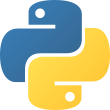

✅ Image loaded successfully!

AI Analysis:


The image shows the Python programming language logo, which consists of two stylized snakes intertwined in a yin-yang pattern. One snake is blue, on the left and top side, with its head pointing to the left. The other snake is yellow, positioned on the right and bottom side, with its head pointing to the right. Each snake has a dot resembling an eye near its head. The overall design is smooth and symmetrical.

In [40]:
# Analyze images
from IPython.display import Image
import requests
from io import BytesIO

# Image URL to analyze - using a clear JPG image
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c3/Python-logo-notext.svg/110px-Python-logo-notext.svg.png"

# Display the image first
print("Image being analyzed:")
try:
    # Download and display the image with better error handling
    response_img = requests.get(image_url, timeout=10)
    response_img.raise_for_status()  # Raise an exception for bad status codes
    
    # Create image object and display
    img = Image(data=response_img.content, width=200)  # Set width for better display
    display(img)
    print("✅ Image loaded successfully!")
    
except requests.exceptions.RequestException as e:
    print(f"❌ Network error loading image: {e}")
    print(f"Image URL: {image_url}")
except Exception as e:
    print(f"❌ Error displaying image: {e}")
    print(f"Image URL: {image_url}")

print("\n" + "="*50)
print("AI Analysis:")
print("="*50)

# Analyze the image with OpenAI
try:
    response = client.responses.create(
        model="gpt-4o",
        input=[
            {"role": "user", "content": "Describe what you see in this image in detail."},
            {
                "role": "user", 
                "content": [{
                    "type": "input_image",
                    "image_url": image_url
                }]
            }
        ]
    )
    
    display(Markdown(response.output_text))
    
except Exception as e:
    print(f"❌ Error analyzing image with OpenAI: {e}")
    print("Make sure your OpenAI API key is set correctly.")

## 7. Streaming Responses

In [15]:
# Stream responses in real-time
stream = client.responses.create(
    model="gpt-4o-mini",
    input="Explain machine learning in simple terms within 100 words.",
    stream=True
)

print("Streaming response:")
for event in stream:
    if hasattr(event, "type") and "text.delta" in event.type:
        print(event.delta, end="", flush=True)

Streaming response:
Machine learning is a type of artificial intelligence that enables computers to learn from data and improve their performance over time without being explicitly programmed. Instead of following fixed rules, machines analyze patterns in data, make predictions, and adapt based on new information. For example, a recommendation system suggests movies by learning your preferences from past choices. Overall, it's about teaching computers to think and learn like humans do, using examples and experience to solve problems.

## 8. Advanced Features

### Background Mode (for reasoning models)

In [ ]:
# Use reasoning models with background processing
response = client.responses.create(
    model="o3-mini",
    input="Solve this complex math problem: Find the derivative of x^3 + 2x^2 - 5x + 3",
    reasoning={"effort": "medium"}
)

display(Markdown(response.output_text))

To find the derivative of the function f(x) = x³ + 2x² – 5x + 3, we'll differentiate each term separately using the power rule. The power rule states that the derivative of x^n is n·x^(n-1).

1. For x³, the derivative is 3x².
2. For 2x², the derivative is 2 × 2x = 4x.
3. For –5x, the derivative is –5.
4. The derivative of the constant 3 is 0.

Putting these together, the derivative f '(x) is:

  f '(x) = 3x² + 4x – 5.


### Error Handling

In [6]:
import openai

try:
    response = client.responses.create(
        model="gpt-4o",
        input="Hello world!"
    )
    print(response.output_text)
    
except openai.RateLimitError:
    print("Rate limit exceeded. Please try again later.")
except openai.APIError as e:
    print(f"API error occurred: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

Hello! How can I assist you today?


## Best Practices

1. **Use appropriate models**: Choose `gpt-4o` for complex tasks, `gpt-4o-mini` for simple operations
2. **Manage conversation state**: Use `previous_response_id` for multi-turn conversations
3. **Leverage built-in tools**: Web search and file search reduce development complexity
4. **Structure outputs**: Use JSON schemas for consistent, parseable responses
5. **Handle errors gracefully**: Implement proper error handling for production applications
6. **Monitor usage**: Track API usage and costs in production environments

## Migration from Chat Completions

The Responses API is backward compatible with Chat Completions, making migration straightforward:

In [ ]:
# Old Chat Completions way
# response = client.chat.completions.create(
#     model="gpt-4o",
#     messages=[{"role": "user", "content": "Hello!"}]
# )

# New Responses API way
response = client.responses.create(
    model="gpt-4o",
    input="Hello!"
)

display(Markdown(response.output_text))

## Conclusion

The Responses API provides a more powerful, unified interface for building sophisticated AI applications with less code and complexity. It combines orchestration logic and integrates built-in tools without requiring custom implementation, making it the preferred choice for new projects.

Key advantages:
- Simplified development experience
- Built-in tools reduce boilerplate code
- Automatic conversation state management
- Enhanced function calling capabilities
- Support for multimodal inputs and structured outputs